# Predictive distribution for Bayesian Linear Regression

The predictive distribution for a linear model of the form $y(x, {\bf w}) = \phi(x)^T {\bf w}$ takes the form
$$
    p(t | x, {\bf t}, \alpha, \beta) = \mathcal{N}\left(t \mid {\bf m}_N^T \phi({\bf x}), \  \frac{1}{\beta} + \phi({\bf x})^T{\bf S}_N\phi({\bf x})\right)
$$

With

$$
    {\bf S}_N^{-1} = {\bf S}_0^{-1} + \beta \Phi^T\Phi\\
    {\bf m}_N = {\bf S}_N({\bf S}_0^{-1}{\bf m}_0 + \beta\Phi^T{\bf t})
$$

---

In this notebook we consider a Gaussian basis function
$$
    \phi_j(x) = \exp\left(-\frac{(x - \mu_j)^2}{2s^2}\right) 
$$

and prior distribution ${\bf w}\sim \mathcal{N}({\bf 0}, \alpha^{-1}{\bf I})$. Hence, the posterior distribution parameters for $\bf w$ become

$$
    {\bf S}_N^{-1} = \alpha^{-1}{\bf I} + \beta \Phi^T\Phi\\
    {\bf m}_N = \beta{\bf S}_N\Phi^T{\bf t})
$$


In [3]:
import numpy as np
import branca
import matplotlib.pyplot as plt

from numpy.linalg import inv

In [4]:
%config InlineBackend.figure_format = "retina"

### Linear basis function of choice

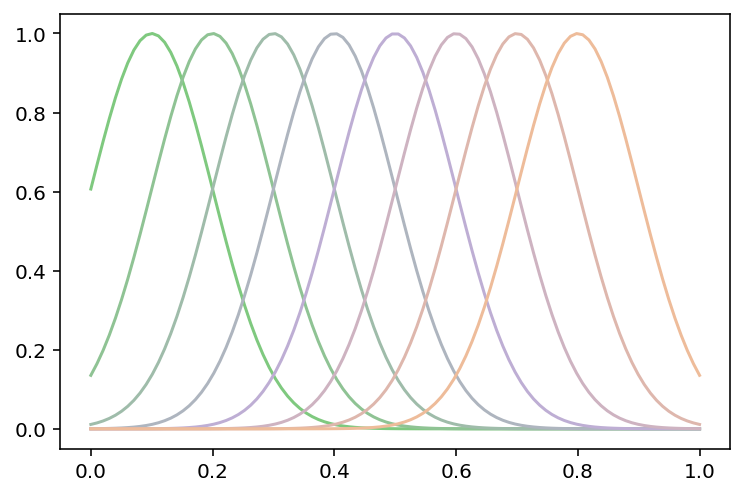

In [5]:
def y(x): return np.sin(2 * np.pi * x)
def gaussian_bf(x, mu, s): return np.exp(-(x - mu) ** 2 / (2 * s ** 2))

x_true = np.linspace(0, 1, 100)
y_true = y(x_true)


colors = branca.colormap.linear.Accent_03
s = 0.1
mu = np.arange(0.1, 0.9, 0.1)
for j, mu_j in enumerate(mu):
    plt.plot(x_true, gaussian_bf(x_true, mu_j, s), c=colors(j / len(mu)))

### A sample of values to learn from

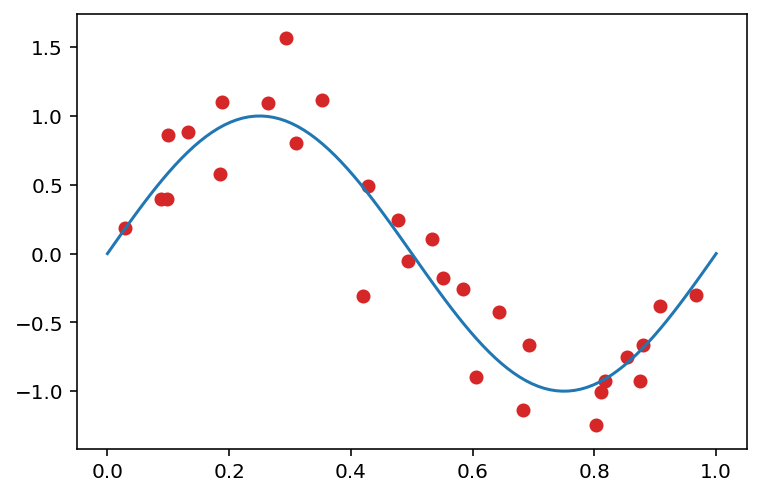

In [6]:
def sample_sinusoidal(S, beta, x_samp=None):
    x_samp = np.random.uniform(0, 1, S)  if x_samp is None else x_samp
    y_samp = np.random.normal(y(x_samp), 1 / np.sqrt(beta), S)
    return x_samp, y_samp

np.random.seed(314159)
precision = 15
x_s, y_s = sample_sinusoidal(30, precision)

plt.plot(x_true, y_true)
plt.scatter(x_s, y_s, c="tab:red")

In [7]:
def fill_basis(x, s, mu):
    Phi = np.column_stack((gaussian_bf(x, mu_j, s) for mu_j in mu))
    # bias term
    Phi = np.column_stack((np.ones_like(x), Phi))
    return Phi

def posterior_weights(alpha, s, beta, mus, x_train, y_train):
    Phi = fill_basis(x_train, s, mus)
    SN = inv(alpha + beta * Phi.T @ Phi)
    mN = beta * SN @ Phi.T @ y_train.reshape(-1, 1)
    return mN, SN

## Estimating the Confidence Intervals for the Regression

In [6]:
def plot_estimate(xt, yt, xrange, yrange, mu, sigma, ax=plt):
    ax.plot(xrange, yrange)
    ax.plot(xrange, mu, c="tab:red")
    ax.fill_between(xrange, mu.ravel() - 2 * sigma,
                     mu.ravel() + 2 * sigma,
                     color="tab:red", alpha=0.2)
    ax.scatter(xt, yt, facecolors="none", edgecolors="tab:red", s=50)
    ax.grid(alpha=0.2);

In [7]:
step = 0.25
mu = np.arange(0, 1 + step, step) # mus to consider for the Gaussian basis functions
s = 0.3
alpha = 0.1

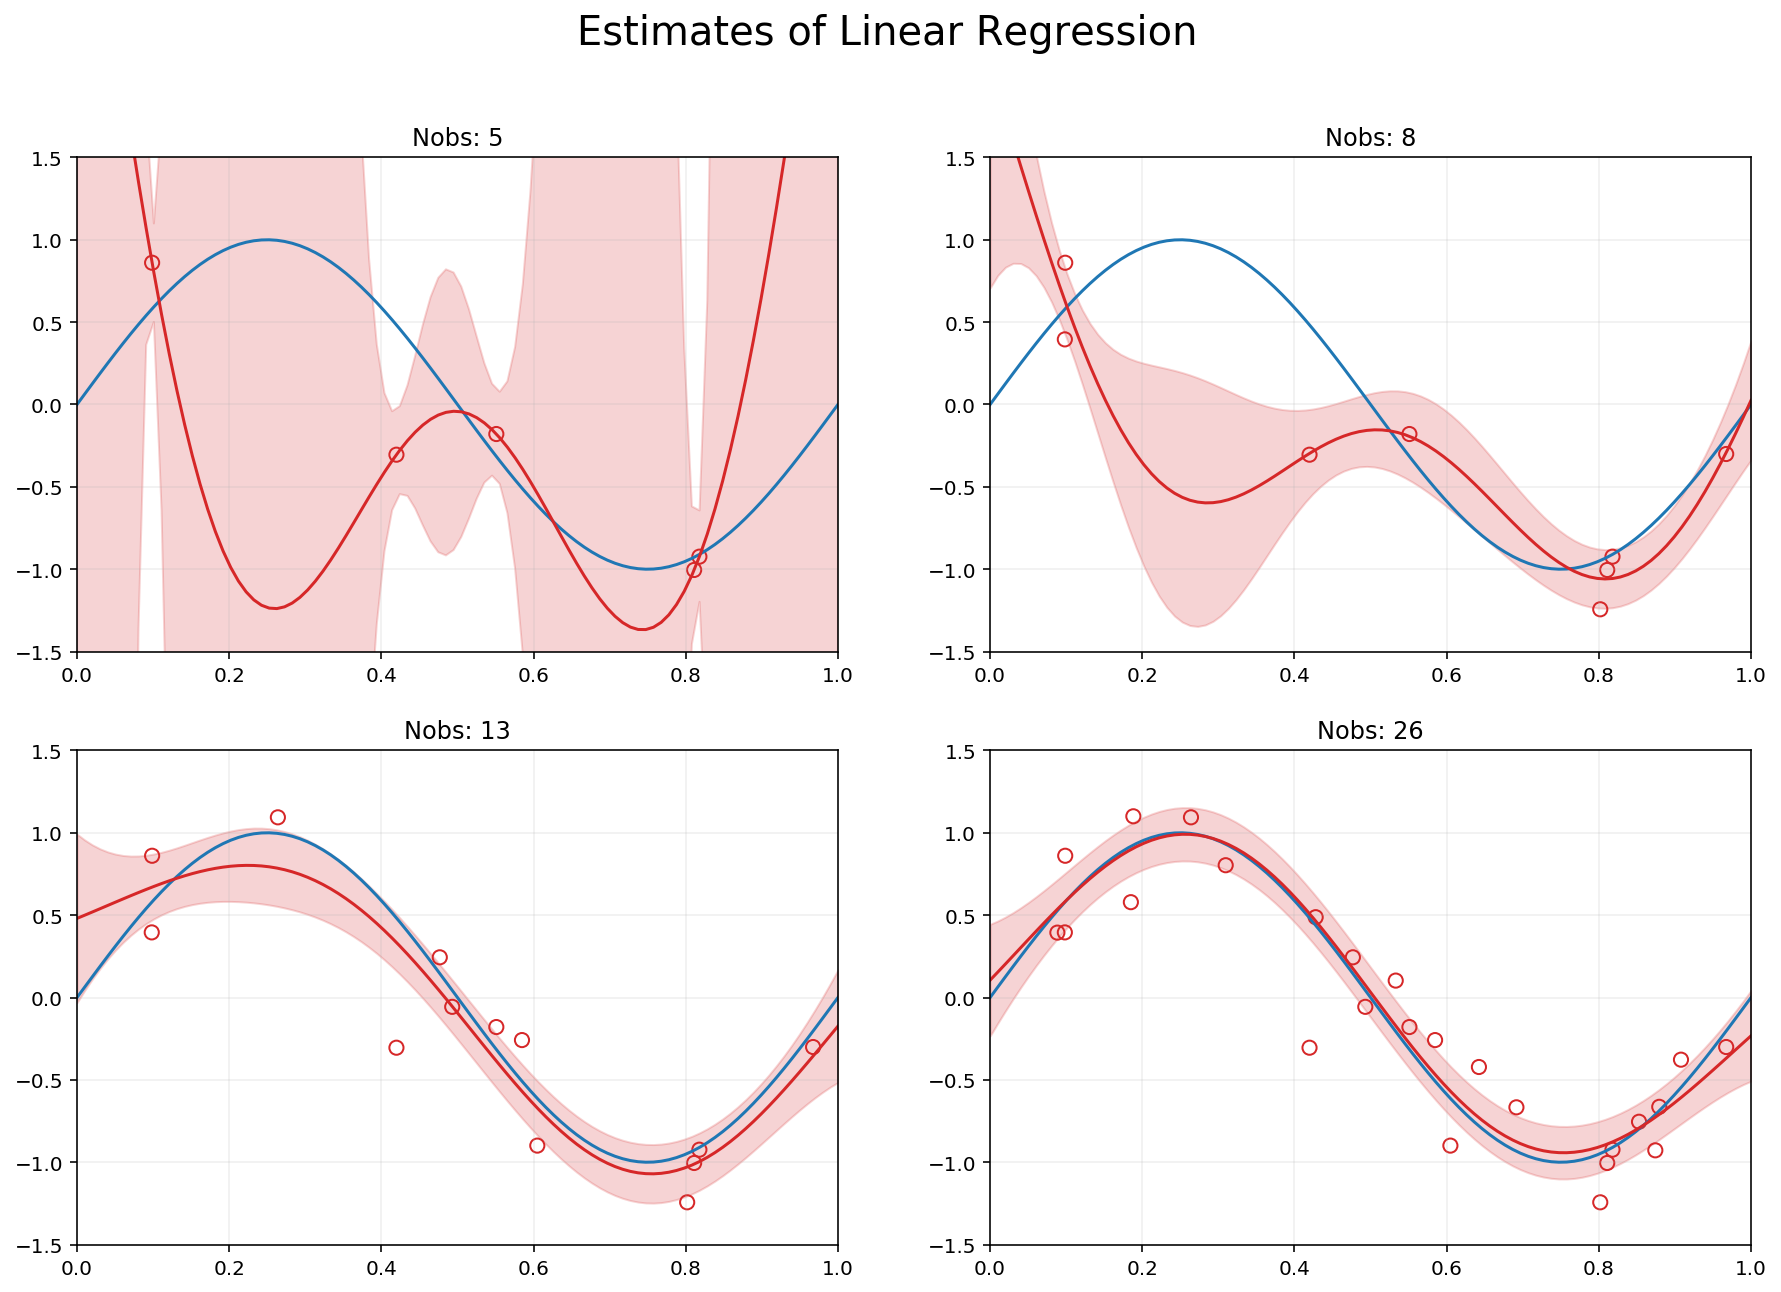

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
vals = [5, 8, 13, 26]
for axi, v in zip(ax.ravel(), vals):
    xtarget = x_s[:v]
    ytarget = y_s[:v]

    mN, SN = posterior_weights(alpha, s, precision, mu, xtarget,  ytarget)
    Phi = fill_basis(x_true, s, mu).T
    mu_pred = Phi.T @ mN
    sigma_pred = 1 / precision + np.diag(Phi.T @ SN @ Phi)
    
    axi.set_xlim(0, 1)
    axi.set_ylim(-1.5, 1.5); 
    axi.set_title(f"Nobs: {v}")
    plot_estimate(xtarget, ytarget, x_true, y_true, mu_pred, sigma_pred, ax=axi)
plt.suptitle("Estimates of Linear Regression", size=20);

> If we use localized basis functions such as Gaussian, then in regions away from the basis function centers, the contribution from the second term in the predictive variance will go to zero

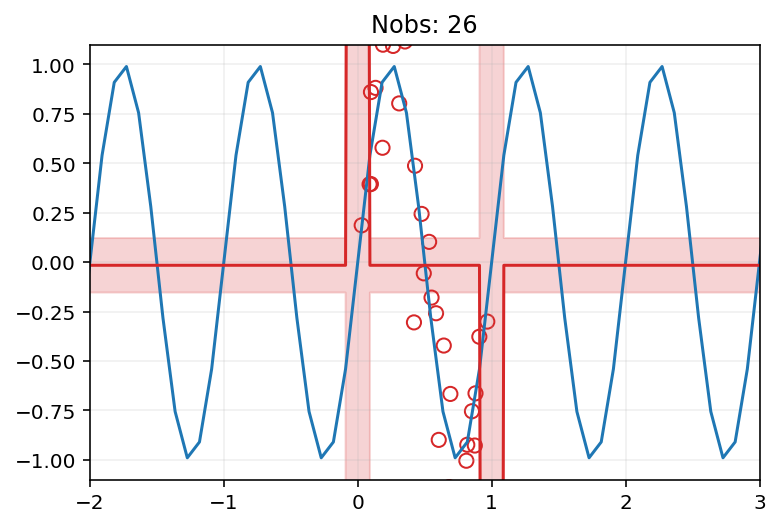

In [9]:
x_true = np.linspace(-4, 5, 100)
y_true = y(x_true)

step = 1
mu = np.arange(0, 1 + step, step) # mus to consider for the Gaussian basis functions
s = 0.01
alpha = 0.1

fig, axi = plt.subplots(1,1)
xtarget = x_s
ytarget = y_s

mN, SN = posterior_weights(alpha, s, precision, mu, xtarget,  ytarget)
Phi = fill_basis(x_true, s, mu).T
mu_pred = Phi.T @ mN
sigma_pred = 1 / precision + np.diag(Phi.T @ SN @ Phi)

axi.set_xlim(-2, 3)
axi.set_ylim(-1.1, 1.1); 
axi.set_title(f"Nobs: {v}")
plot_estimate(xtarget, ytarget, x_true, y_true, mu_pred, sigma_pred, ax=axi)